In [55]:
from pathlib import Path
from IPython.display import display

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import spotipy
import lib_spotify_app.api_adapter as api_adapter

pd.set_option('max_columns', None)

In [56]:
df = pd.read_csv(Path(r'private/data.csv'), sep='\t')

 Let's retrieve the most useful column for our analysis like:
 * related to music features
 * to classify it (name, etc...)
 * release date (could be related to a specific era)

In [57]:
col = [
    'added_at',
    'album.id',
    'album.images.0.height',
    'album.images.0.url',
    'album.images.0.width',
    'album.name',
    'album.release_date',
    'album.release_date_precision',
    'artists.id',
    'artists.name',
    'duration_min',
    'id',
    'external_urls.spotify',
    'name',
    'popularity',
    'preview_url',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature'
]

feat = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
]

Let's have a general view of the kind of music I listen to

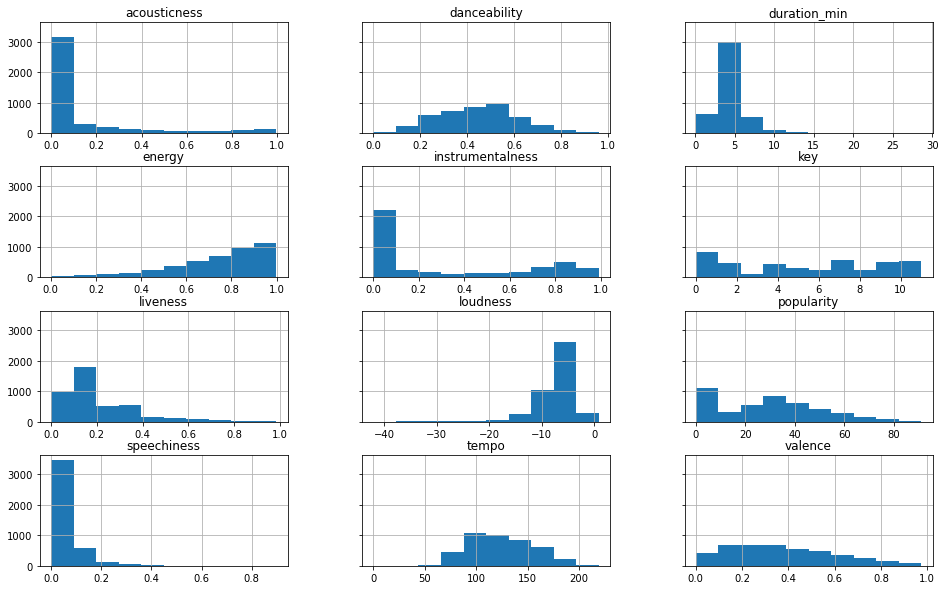

In [58]:
df[feat+['duration_min', 'popularity']].hist(sharey=True, figsize=(16, 10));

There is more 10 audio features given by Spotify, to view our songs in 1 view, I will apply a dimensionnality reduction algorithm to project in a 2D plane.
After that I will cluster on this plane.
Then we can see if the clustering make sense...

For T-SNE I applied 2 methods:
* scaled the data and apply euclidian
* apply mahalanobis distance aside and use it as a pre-calculated distance
Clearly. The mahalanobis distance gives better result (as it focus on group of data in similar distribution)

I tune the perplexity = n^(1/2) with n the number of observations (as KNN rule of thumbs)

In [59]:
from sklearn.preprocessing import minmax_scale
normalized = df[feat].apply(lambda x: (x - x.mean()) / x.std())
# normalized = df[feat].apply(minmax_scale)

In [60]:
from scipy.spatial.distance import pdist, squareform
mahalanobis_dist = squareform(pdist(df[feat], metric='mahalanobis'))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 4308 samples in 0.025s...
[t-SNE] Computed neighbors for 4308 samples in 0.271s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4308
[t-SNE] Computed conditional probabilities for sample 2000 / 4308
[t-SNE] Computed conditional probabilities for sample 3000 / 4308
[t-SNE] Computed conditional probabilities for sample 4000 / 4308
[t-SNE] Computed conditional probabilities for sample 4308 / 4308
[t-SNE] Mean sigma: 0.443900
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.168755
[t-SNE] KL divergence after 10000 iterations: 1.843975


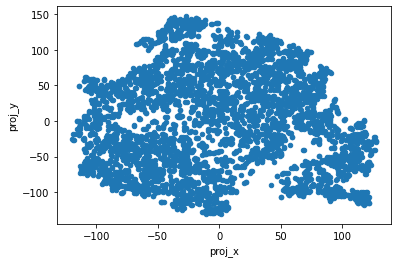

In [64]:
from sklearn.manifold import TSNE

mdl_proj = TSNE(
    perplexity=20,
    n_jobs=3,
    n_iter=10**4,
    n_iter_without_progress=10**3,
    verbose=1,
    metric='precomputed',
    random_state=0
)

df[['proj_x', 'proj_y']] = pd.DataFrame(mdl_proj.fit_transform(mahalanobis_dist))
df[['proj_x', 'proj_y']].plot(kind='scatter', x='proj_x', y='proj_y');

In [66]:
from umap import UMAP
mdl_proj = UMAP(n_neighbors=30, metric='mahalanobis')

df[['proj_x', 'proj_y']] = pd.DataFrame(mdl_proj.fit_transform(df[feat]))
df[['proj_x', 'proj_y']].plot(kind='scatter', x='proj_x', y='proj_y');

Let's see a bit where the supergenre calculated previously are in this projection

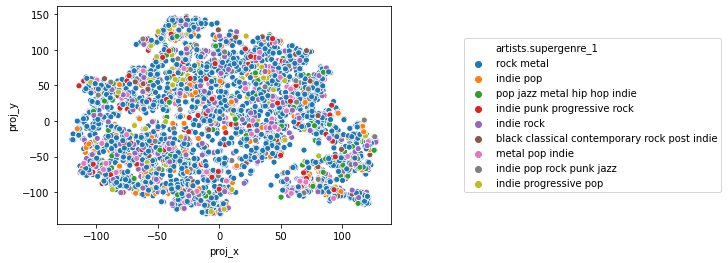

In [65]:
g = sns.scatterplot(data=df, x='proj_x', y='proj_y', hue='artists.supergenre_1', legend='full');
g.legend(loc='center right', bbox_to_anchor=(2, 0.5), ncol=1);

I fine-tuned HDBSCAN with the min_cluster_size and let min_samples be found
min_cluster_size should be similar to an album size (10-20) or a playlist size (50-100)
the size of 16 seems the magic (other size around does not give similar clusters number and size)

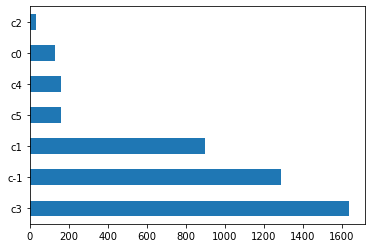

In [78]:
from hdbscan import HDBSCAN

df['clusters'] = HDBSCAN(min_cluster_size=20, min_samples=50).fit_predict(df[['proj_x', 'proj_y']], min)
df['clusters'] = df['clusters'].map(lambda x: f'c{x}')

df['clusters'].value_counts().plot(kind='barh');

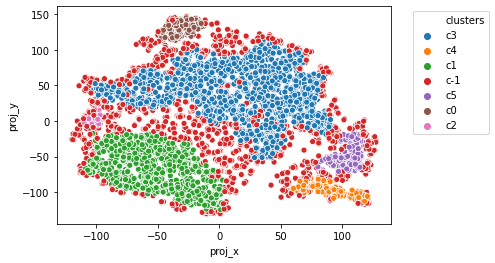

In [79]:
sns.scatterplot('proj_x', 'proj_y', data=df, hue='clusters');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

Let's see if those clusters make sense by printing each 10 most popular songs

In [87]:
col = feat+[
    'clusters',
    'proj_x',
    'proj_y',
    'popularity',
    'duration_min',
    'name',
    'artists.name',
    'album.name',
    'artists.genres',
    'artists.supergenres',
    'artists.supergenre_1',
    'external_urls.spotify',
    'preview_url'
]

df_top5 = df[col].groupby('clusters').apply(
    lambda x: x.dropna().sort_values('popularity').head(5)
)

df_top5

danceability  energy  key  loudness  speechiness  acousticness  \
clusters                                                                        
c-1      722         0.3380  0.9610    7    -5.291       0.0425      0.056200   
         3793        0.1510  0.5810    9   -12.968       0.0531      0.323000   
         111         0.2540  0.3500    2   -13.698       0.0314      0.749000   
         677         0.5160  0.4120   11   -12.261       0.0724      0.063000   
         1197        0.7650  0.6070    4    -7.780       0.0423      0.236000   
c0       2997        0.6320  0.7320    8    -5.934       0.2750      0.001780   
         1104        0.0985  0.9670    3    -4.892       0.3690      0.001620   
         2031        0.5270  0.3310    8   -12.123       0.5510      0.404000   
         2938        0.5830  0.7730    1    -7.722       0.2070      0.042700   
         231         0.2100  0.9750    4    -3.978       0.3250      0.000666   
c1       629         0.2230  0.7830   11    -8.788       0.0660      0.117000   
         650         0.4930  0.7110    8    -6.907       0.1170      0.003180   
         2266        0.1380  0.9800    4    -8.147       0.1340      0.000085   
         1425        0.3760  0.9070   10    -5.817       0.0648      0.012200   
         1768        0.3630  0.7180    5    -9.213       0.0507      0.225000   
c2       1333        0.1550  0.9110    4    -5.190       0.0805      0.000026   
         3685        0.3550  0.6210   10    -9.489       0.0325      0.031100   
         3683        0.3180  0.7230    7    -8.321       0.0434      0.012700   
         645         0.3920  0.9010    5    -7.528       0.0820      0.000058   
         932         0.5350  0.8860   10    -6.298       0.0593      0.000670   
c3       2410        0.3860  0.7840    2    -4.256       0.0380      0.000021   
         37          0.5730  0.7060    6    -6.582       0.0537      0.002860   
         38          0.4480  0.8300    7    -6.559       0.0789      0.000435   
         28          0.4930  0.8830    7    -6.235       0.0523      0.003080   
         31          0.4770  0.8040    9    -6.879       0.0466      0.009370   
c4       110         0.1540  0.1050    7   -20.435       0.0380      0.961000   
         112         0.4520  0.0894    4   -18.656       0.0928      0.981000   
         2994        0.5050  0.3680   11   -12.976       0.0404      0.829000   
         401         0.3820  0.1200    3   -23.196       0.0374      0.979000   
         402         0.3820  0.1200    3   -23.196       0.0374      0.979000   
c5       3513        0.5630  0.4840    3    -7.827       0.0311      0.755000   
         1471        0.5090  0.4170    9   -10.101       0.0273      0.968000   
         1473        0.5870  0.7600    0    -3.957       0.0290      0.580000   
         1469        0.4780  0.3990    0    -9.691       0.0264      0.660000   
         1470        0.6680  0.5510    7    -9.663       0.0285      0.769000   

               instrumentalness  liveness  valence    tempo clusters  \
clusters                                                               
c-1      722           0.031600    0.3420   0.6770  100.807      c-1   
         3793          0.773000    0.2360   0.4550   73.495      c-1   
         111           0.000711    0.7230   0.1600   67.737      c-1   
         677           0.801000    0.5620   0.1570  136.188      c-1   
         1197          0.011400    0.1120   0.3500   90.990      c-1   
c0       2997          0.259000    0.2930   0.3030  123.991       c0   
         1104          0.013400    0.1520   0.0383   74.643       c0   
         2031          0.145000    0.6160   0.3900  180.110       c0   
         2938          0.000022    0.2790   0.5200  167.017       c0   
         231           0.340000    0.1070   0.1400  183.317       c0   
c1       629           0.875000    0.1090   0.1580  161.570       c1   
         650           0.767000    0.0698   0.1290  130.581       c1   
         

An interactive plot with px would help see where the songs are in the projection and what they are

In [108]:
df_top5['artists.genres.str'] = df_top5['artists.genres'].apply(
    lambda x: ' '.join(x)
)
# df_top5['artists.supergenres.str'] = df['artists.supergenres'].apply(
#     lambda x: ' '.join(x)
# )
df_top5['artists.name.str'] = df_top5['artists.name'].apply(
    lambda x: ', '.join(x)
)

df_top5['text'] = df_top5.apply(
    lambda x:
        f'Track: {x["name"]}<br>' +
        f'Artist: {x["artists.name.str"]}<br>' +
        f'Album: {x["album.name"]}<br>' +
        f'Genres: {x["artists.genres.str"]}<br>'+
        #f'Super Genres: {x["artists.supergenres.str"]}<br>' +
        f'Super Genre 1: {x["artists.supergenre_1"]}<br>' +
        f'Preview Song: <a href="{x["preview_url"]}">Play</a><br>' +
        f'Full Song: <a href="{x["external_urls.spotify"]}">Play</a><br>',
    axis=1
)

df_top5['size'] = df_top5['popularity'].apply(lambda x: np.log10(x+1))

In [109]:
import webbrowser
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

def click_event(trace, points, state):
    print('test')
    display(points.customdata)
    [webbrowser.open(point.customdata) for point in points]

fig = go.FigureWidget()

for group_name, df_group in df_top5.groupby('clusters'):
    fig.add_trace(go.Scattergl(
        x=df_group['proj_x'],
        y=df_group['proj_y'],
        name=group_name,
        text=df_group['text'],
        marker_size=df_group['size'],
        customdata=df_group['preview_url'],
        ids=df_group.index.to_list(),
    ))
    
# Tune marker appearance and layout
fig.update_traces(
    mode='markers', 
    hoverinfo='text',
    marker=dict(sizeref=2.*max(df_top5['size'])/(5.**2),
                line_width=0)
)
fig.for_each_trace(
        lambda trace: trace.on_click(click_event, append=True)
    )

FigureWidget({
    'data': [{'customdata': array([nan, nan, nan, ...,
                                   'http…